## This isn't running the most up to date version anymore

In [ ]:
import numpy as np
from math import acos, sin, cos, tan
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp',
  'Roll', 'Pitch', 'Yaw']

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]

yaw = df['Yaw'].values
pitch = df['Pitch'].values
roll = df['Roll'].values

In [3]:
def sind(x):
    return sin(np.deg2rad(x))

def cosd(x):
    return cos(np.deg2rad(x))

def tand(x):
    return tan(np.deg2rad(x))

def acosd(x):
    return np.rad2deg(acos(x))

def convert_ffYPR_matrix(alpha, beta, gamma):
    '''
    This function returns the YPR in the fixed world frame.
    Data collected from the Vector Nav is in the body frame and must be transformed
     in order to do the necessary math later
    '''
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
             [0, cosd(alpha), -sind(alpha)],
             [0, sind(alpha), cosd(alpha)]])

    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
            [0, 1, 0],
            [-sind(beta), 0, cosd(beta)]])

    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
             [sind(gamma), cosd(gamma), 0],
             [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha

    return R


def get_ffYPR_theta(bYPR):
    """Accepts body frame YPR, returns the FIXED FRAME YPR"""
    
    R = convert_ffYPR_matrix(bYPR[0], bYPR[1], bYPR[2])

    ffyaw = acosd(np.dot(R[:,1], [0, 1, 0]))
    ffpitch = acosd(np.dot(R[:,2], [0, 0, 1]))
    ffroll = acosd(np.dot(R[:,0], [1, 0, 0]))
    
    ADJ_ffpitch = ffpitch*-1 + 180
    #ADJ_ffroll = ffroll*-1 + 180 <-- USE THIS WHEN NOT USING ABG CONVERSION
    
    ffYPR = np.array([ffyaw, ADJ_ffpitch, ffroll])
    
    return ffYPR


def map_roll(x):
    return abs(np.mod(x - 180.0, 360.0) - 180.0)


def compare_change(theta_prev, theta_new, threshold=50):
    if type(threshold) is int or type(threshold) is float:
        # You have specified a single acceptable value, shared for all 3 axes
        roll_thresh, pitch_thresh, yaw_thresh = threshold, threshold, threshold
        individual = False
    elif len(threshold)==3:
        # You have given YPR separate thresholds
        roll_thresh, pitch_thresh, yaw_thresh = threshold[0], threshold[1], threshold[2]
        individual = True
    else:
        raise("TypeError: threshold parameter should either be an int or a 3x1 vector of ints")
    
    should_accept = True
    
    # Map the roll so it is triangular, peaks at 180. 0->0, 180->180, 360->0
    roll_prev = map_roll(theta_prev[0])
    roll_new = map_roll(theta_new[0])

    if individual:
        # DEALING WITH INDIVUDAL AXIS ROTATIONS
        # Roll
        if roll_prev - roll_new > roll_thresh:
            print("Too much ROLL detected.  Image should be discarded")
            return False
        # Pitch
        elif theta_prev[1] - theta_new[1] > pitch_thresh:
            print("Too much PITCH detected.  Image should be discarded")
            return False
        # Yaw
        elif theta_prev[2] - theta_new[2] > yaw_thresh:
            print("Too much YAW detected.  Image should be discarded")
            return False
        
    else:
        # DEALING WITH ALL AXES ROTATIONS (E.G. IN COMBINATION)
        theta_prev[0] = roll_prev
        theta_new[0] = roll_new
        
        dTheta = theta_new - theta_prev
        
        #if np.linalg.norm(dTheta) > threshold: 
        # ^Norm doesn't have a direct meaning like the difference in angle does
        if (dTheta > threshold).sum() > 0:
            return False

    return should_accept


# This builds the first orientation matrix
def init_orientation(bYPR):
    ffYPR = get_ffYPR_theta(bYPR)
    return ffYPR


def convert_abg(bYPR):
    # Normally, alpha beta gamma are yaw pitch roll
    # Our IMU placement is such that the roll axis of the IMU is the pitch of the vehicle
    # So let's just switch things around
    
    gamma = bYPR[0]  # Yaw
    alpha = bYPR[1]  # Pitch
    beta = bYPR[2]  # Roll

    # Essentially we just returned a switched around version of bYPR
    return np.array([alpha, beta, gamma])


# Put this before the incoming images
def judge_image(prev_orientation, bYPR):
    # Account for IMU misalignment with launch vehicle frame
    bYPR = convert_abg(bYPR)
    # Convert IMU data from body frame to fixed frame
    ffYPR = get_ffYPR_theta(bYPR)
    # Compare current thetas to previous orientation
    if compare_change(prev_orientation, ffYPR):
        return True, ffYPR
    else:
        return False, prev_orientation

In [4]:
def get_IMU_data(df, row_index):
    bYPR = np.array([df.iloc[row_index, 1], df.iloc[row_index, 2], df.iloc[row_index, 3]])
    return bYPR

## Unit Testing

In [5]:
L = len(tdata)
bYPR = get_IMU_data(df, 0)
po = init_orientation(bYPR)

Ls = 93

my_bools = [0] * L#s
my_pos = [0] * L#s

In [6]:
df.head()

,Timestamp,Yaw,Pitch,Roll
0,583.352,-139.761,0.463927,-179.001
1,583.377,-139.697,0.466188,-179.002
2,583.402,-139.673,0.664403,-178.855
3,583.428,-139.761,0.772829,-178.767
4,583.453,-140.238,0.828463,-178.879


In [7]:
# To simulate 1 frame per second: range(0, L, 43)

for i, val in enumerate(range(L)): 
    # Collect incoming IMU data in real time
    bYPR = get_IMU_data(df, val)
    my_bool, po = judge_image(po, bYPR)
    
    my_bools[i] = my_bool
    my_pos[i] = po

In [8]:
d = {"my_bool": my_bools, "po": my_pos}
df2 = pd.DataFrame(d)

In [9]:
ffyaw = [pos[0] for pos in my_pos]
ffpitch = [pos[1] for pos in my_pos]
ffroll = [pos[2] for pos in my_pos]

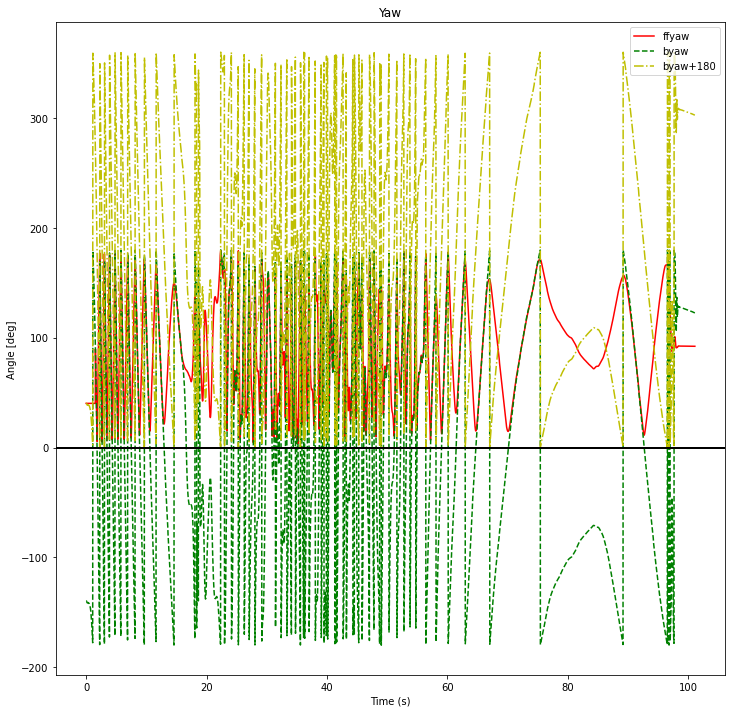

In [10]:
fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffyaw, 'r', label='ffyaw')
l3 = ax.plot(tdata, yaw, '--g', label='byaw')
l4 = ax.plot(tdata, yaw+180, '-.y', label='byaw+180')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

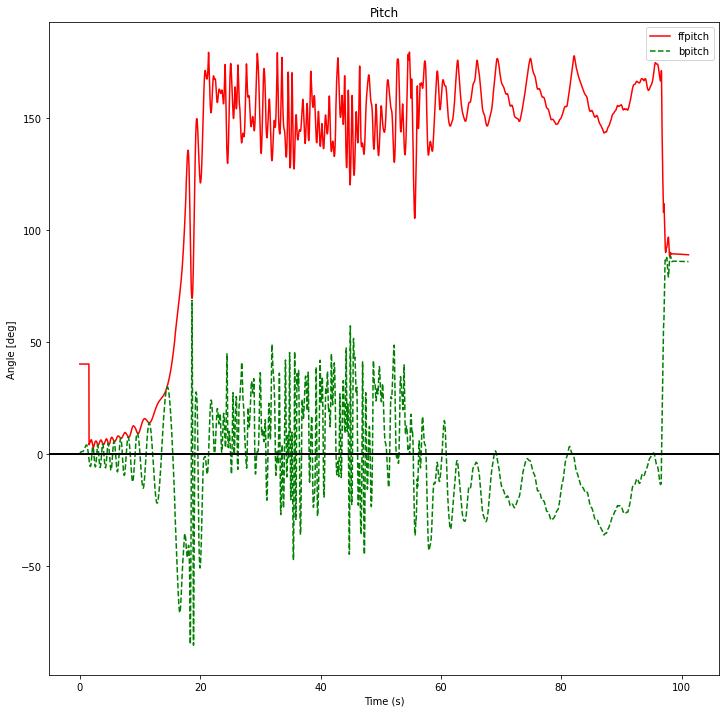

In [11]:
fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffpitch, 'r', label='ffpitch')
l3 = ax.plot(tdata, pitch, '--g', label='bpitch')
#l4 = ax.plot(tdata, yaw+180, '-.y', label='byaw+180')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Pitch")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

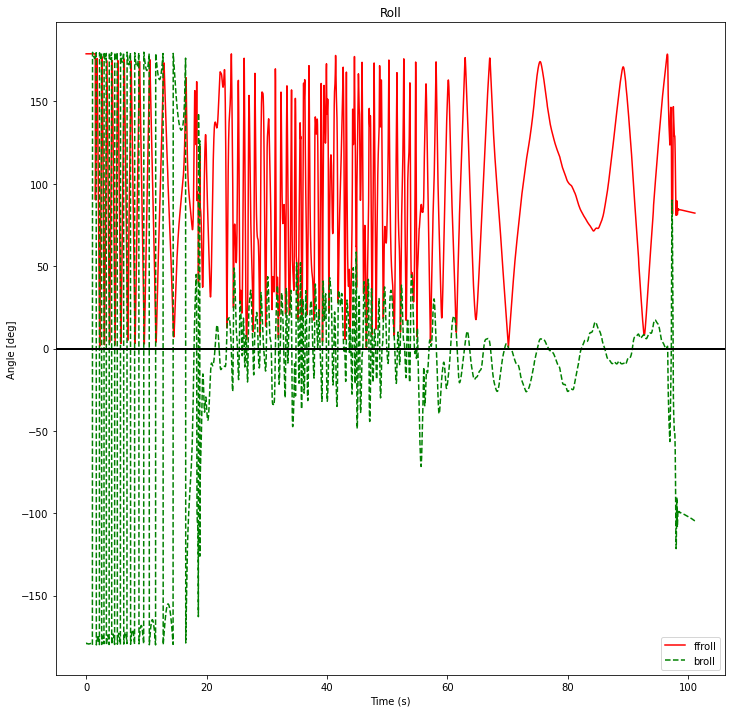

In [12]:
fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffroll, 'r', label='ffroll')
l3 = ax.plot(tdata, roll, '--g', label='broll')
#l4 = ax.plot(tdata, yaw+180, '-.y', label='byaw+180')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Roll")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()